In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#ALL RIGHTS RESERVED BY BU-ALI SINA UNIVERSITY (COMPUTER ENGINEERING DEPARTMENT ) - SEP 2023
import os
# !pip install unrar


In [ ]:
# !unzip Challengdata.zip


In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random

## Seeding
seed = 2023
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [4]:
w, h = 304,304

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define paths for images and masks
image_path_template = "drive/MyDrive/Challengdata/train_brain/v{}.png"
mask_path_template = "drive/MyDrive/Challengdata/train_mask/m{}.png"
output_path_brain = "drive/MyDrive/train_brain/"
output_path_mask = "drive/MyDrive/train_mask/"

# Find the maximum index in the existing dataset
existing_indices = [int(file[1:-4]) for file in os.listdir("drive/MyDrive/Challengdata/train_mask/") if file.startswith("m") and file.endswith(".png")]
max_existing_index = max(existing_indices)

end_index = max_existing_index

# Create output directories if they don't exist
os.makedirs(output_path_brain, exist_ok=True)
os.makedirs(output_path_mask, exist_ok=True)

# Data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to apply data augmentation to an image and save it
def augment_and_save(image_path, mask_path, output_brain_path, output_mask_path, new_index, num_augmented=5):
    img = load_img(image_path)
    mask = load_img(mask_path)

    x = img_to_array(img)
    y = img_to_array(mask)

    x = x.reshape((1,) + x.shape)
    y = y.reshape((1,) + y.shape)

    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=output_path_brain, save_prefix=f'v{new_index}', save_format='png'):
        i += 1
        if i >= num_augmented:
            break

    i = 0
    for batch in datagen.flow(y, batch_size=1, save_to_dir=output_path_mask, save_prefix=f'm{new_index}', save_format='png'):
        i += 1
        if i >= num_augmented:
            break

# Apply data augmentation and save augmented images
new_index = end_index + 1
for original_index in range(3, end_index + 1):
    image_path = image_path_template.format(original_index)
    mask_path = mask_path_template.format(original_index)
     # Adjust for the starting index
    augment_and_save(image_path, mask_path, output_path_brain, output_path_mask, new_index)
    new_index = new_index  +1

print("Data augmentation completed.")


# **Data Reading and Train test split**

In [ ]:
import os

def rename_and_save_images(directory):
    # Get a list of files in the directory
    files = os.listdir(directory)

    # Create a dictionary to store the current index for each prefix
    index_dict = {}

    for filename in files:
        # Split the filename using the underscore
        parts = filename.split("_")
        if len(parts) >= 3 and parts[1].isdigit():
            prefix = parts[0]
            index = int(parts[1])

            # Check if the prefix is in the dictionary
            if prefix in index_dict:
                # Use the stored index and increment it
                index_dict[prefix] += 1
            else:
                # If the prefix is not in the dictionary, initialize the index to 0
                index_dict[prefix] = 0

            # Use the index from the dictionary in the new filename
            new_filename = f"{prefix}_{index_dict[prefix]}.png"

            # Rename the file
            os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))

            print(f"Renamed: {filename} to {new_filename}")

# Replace 'path_to_images_directory' with the path to the directory containing your images
rename_and_save_images('drive/MyDrive/Challengdata/train_mask/')
rename_and_save_images('drive/MyDrive/Challengdata/train_brain/')


In [6]:
import os

def rename_and_save_images(directory):
    # Get a list of files in the directory
    files = os.listdir(directory)

    # Create a dictionary to store the current index for each prefix
    index_dict = {}

    for filename in files:
        # Split the filename using the underscore
        parts = filename.split("_")
        if len(parts) >= 3 and parts[1].isdigit():
            prefix = parts[0]
            index = int(parts[1])

            # Check if the prefix is in the dictionary
            if prefix in index_dict:
                # Use the stored index and increment it
                index_dict[prefix] += 1
            else:
                # If the prefix is not in the dictionary, initialize the index to 0
                index_dict[prefix] = 0

            # Use the index from the dictionary in the new filename
            new_filename = f"{prefix}_{index_dict[prefix]}.png"

            # Rename the file
            os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))

            print(f"Renamed: {filename} to {new_filename}")

# Replace 'path_to_images_directory' with the path to the directory containing your images
rename_and_save_images('drive/MyDrive/Challengdata/train_mask/')
rename_and_save_images('drive/MyDrive/Challengdata/train_brain/')
import glob
train = glob.glob("drive/MyDrive/Challengdata/train_brain/*.png")
train_mask = glob.glob("drive/MyDrive/Challengdata/train_mask/*.png")
# combined_data = list(zip(train, train_mask))
# random.shuffle(combined_data)

# # Unzip the shuffled list
# train, train_mask = zip(*combined_data)
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 165
Total Mask Image : 165


In [7]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)


In [8]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

0it [00:00, ?it/s]

In [9]:
train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

total_samples = len(X)
train_samples = int(total_samples * train_ratio)
test_samples = int(total_samples * test_ratio)
val_samples = total_samples - train_samples - test_samples

images_train, masks_train = X[:train_samples], y[:train_samples]
images_test, masks_test = X[train_samples:train_samples+test_samples], y[train_samples:train_samples+test_samples]
images_val, masks_val = X[-val_samples:], y[-val_samples:]

In [ ]:
# # Split train and valid
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# gc.collect()


# **Visualization the image and It masks**

62


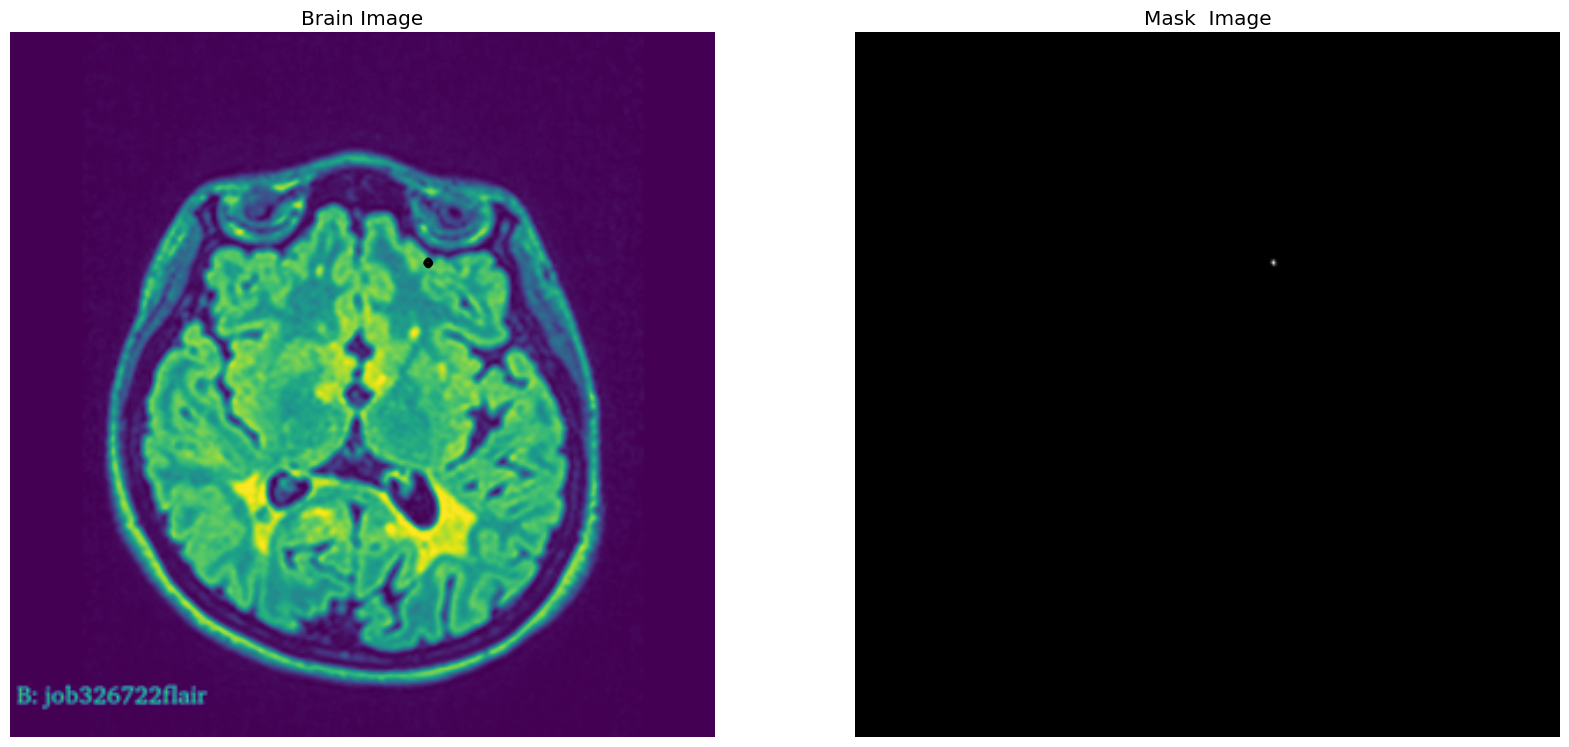

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0,len(images_train))
has_mask = masks_train[ix].max() > 0 # salt indicator
print(ix)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(images_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(masks_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Brain Image')
ax1.set_axis_off()
ax2.imshow(masks_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask  Image')
ax2.set_axis_off()

In [10]:
from keras import backend as K
from keras.layers import Input, Conv2D, BatchNormalization, Activation, concatenate, AvgPool2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf
import gc

dropout_rate = 0.25

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    return x

def UnetPP(input_shape, n_labels, using_deep_supervision=False):

    nb_filter = [32, 64, 128, 256, 512]

    # Set image data format to channels last
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1', padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same')(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    # Concatenate the output layers for deep supervision
    concat_output = concatenate([nestnet_output_1, nestnet_output_2, nestnet_output_3, nestnet_output_4], name='concat_output', axis=bn_axis)

    if using_deep_supervision:
        model = Model(inputs=inputs, outputs=[nestnet_output_1, nestnet_output_2, nestnet_output_3, nestnet_output_4, concat_output])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    return model


In [11]:
from keras import backend as K
K.clear_session()

# del model
model = UnetPP(input_shape = (304, 304,3), n_labels=1)
metrics = ["accuracy",
           tf.keras.metrics.AUC(),
          #  tf.keras.metrics.MeanIoU(num_classes=2),
           tf.keras.metrics.SensitivityAtSpecificity(0.5),
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()


287

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 304, 304, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 304, 304, 32)         896       ['input_image[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 304, 304, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 304, 304, 32)         0         ['batch_normalization[0][0

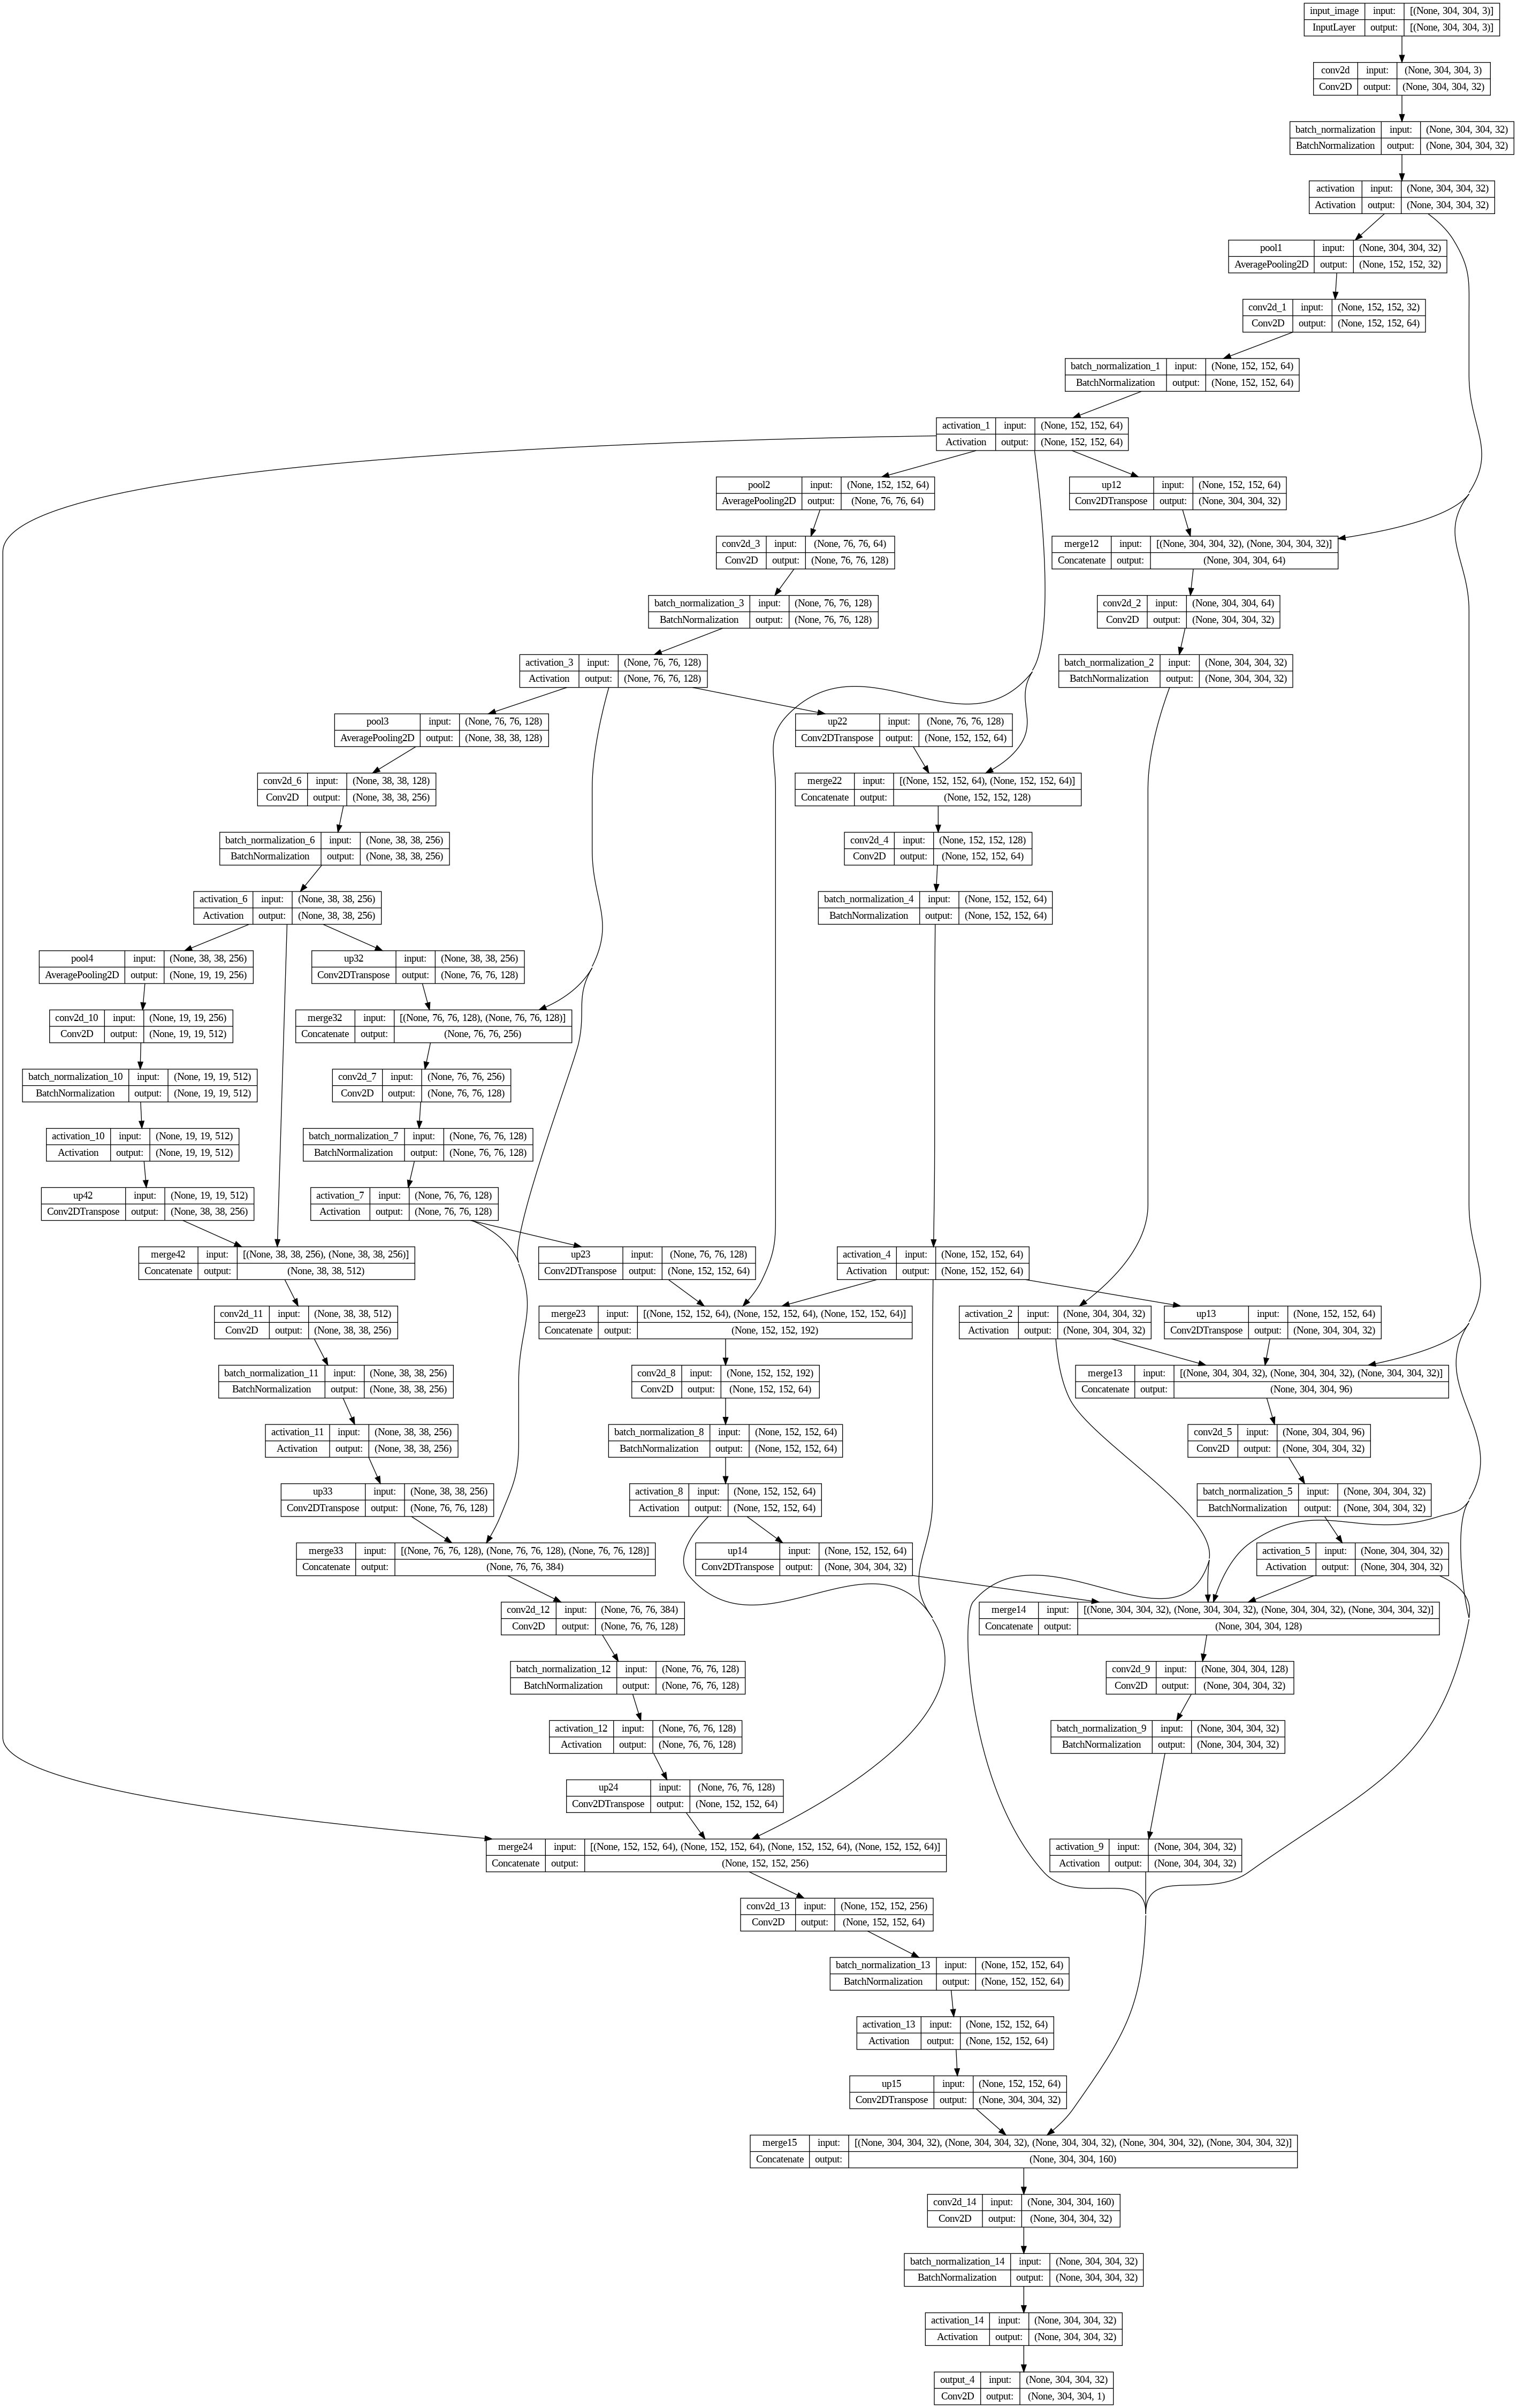

In [ ]:
model.summary()
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="unet.png", show_shapes=True)

In [12]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-UnetPP.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataUnetPP.csv"),
    TensorBoard(log_dir='./logs')
]

In [13]:
with tf.device("/gpu:0"):
  results = model.fit(images_train, masks_train, batch_size=5, epochs=10, callbacks=callbacks, validation_data=(images_val, masks_val), use_multiprocessing=True)



Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.9081 - auc: 0.5667 - sensitivity_at_specificity: 0.5948 - specificity_at_sensitivity: 0.5685
Epoch 1: val_loss improved from inf to 0.53270, saving model to model-UnetPP.h5
23/23 [==============================] - 47s 545ms/step - loss: 0.4248 - accuracy: 0.9081 - auc: 0.5667 - sensitivity_at_specificity: 0.5948 - specificity_at_sensitivity: 0.5685 - val_loss: 0.5327 - val_accuracy: 0.9667 - val_auc: 0.4566 - val_sensitivity_at_specificity: 0.4391 - val_specificity_at_sensitivity: 0.4097 - lr: 0.0010
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9983 - auc: 0.7030 - sensitivity_at_specificity: 0.8280 - specificity_at_sensitivity: 0.7539
Epoch 2: val_loss improved from 0.53270 to 0.42274, saving model to model-UnetPP.h5
23/23 [==============================] - 7s 308ms/step - loss: 0.2124 - accuracy: 0.9983 - auc: 0.7030 - sensitivity_at_specificity: 0.8280

In [14]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
9,0.046124,0.998323,0.748059,0.830014,0.753671,0.065393,0.998056,0.707460,0.827112,0.715366,0.001
8,0.052881,0.998323,0.738963,0.846844,0.782547,0.080346,0.998056,0.727718,0.878847,0.772645,0.001
7,0.061232,0.998323,0.733954,0.867041,0.776391,0.098165,0.998056,0.733661,0.863130,0.766700,0.001
6,0.071557,0.998323,0.745344,0.870968,0.756211,0.119101,0.998056,0.731953,0.890635,0.732939,0.001
5,0.084695,0.998323,0.726101,0.875849,0.752859,0.154638,0.998056,0.755417,0.880485,0.779968,0.001
4,0.100694,0.998323,0.721168,0.860309,0.735275,0.194471,0.998056,0.732038,0.836280,0.761714,0.001
3,0.125418,0.998323,0.712614,0.872146,0.723366,0.262197,0.998056,0.732122,0.843484,0.777137,0.001
2,0.160849,0.998320,0.718976,0.885835,0.740040,0.357019,0.998056,0.580320,0.561231,0.560068,0.001
1,0.212401,0.998322,0.702960,0.827994,0.753920,0.422737,0.998056,0.714748,0.778978,0.762709,0.001
0,0.424811,0.908087,0.566732,0.594783,0.568477,0.532703,0.966708,0.456612,0.439096,0.409729,0.001


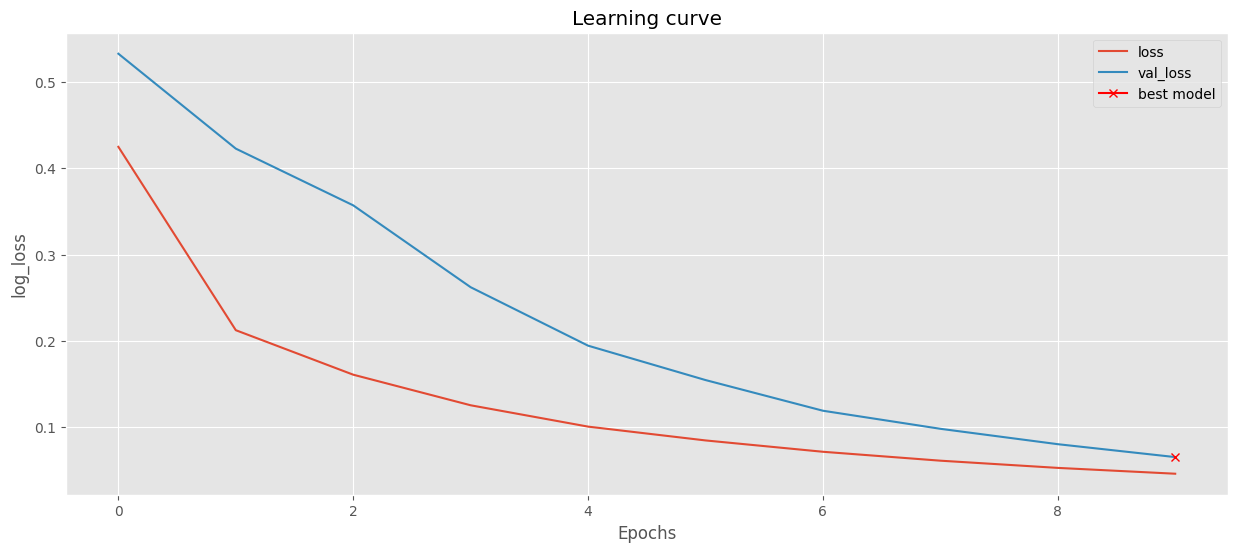

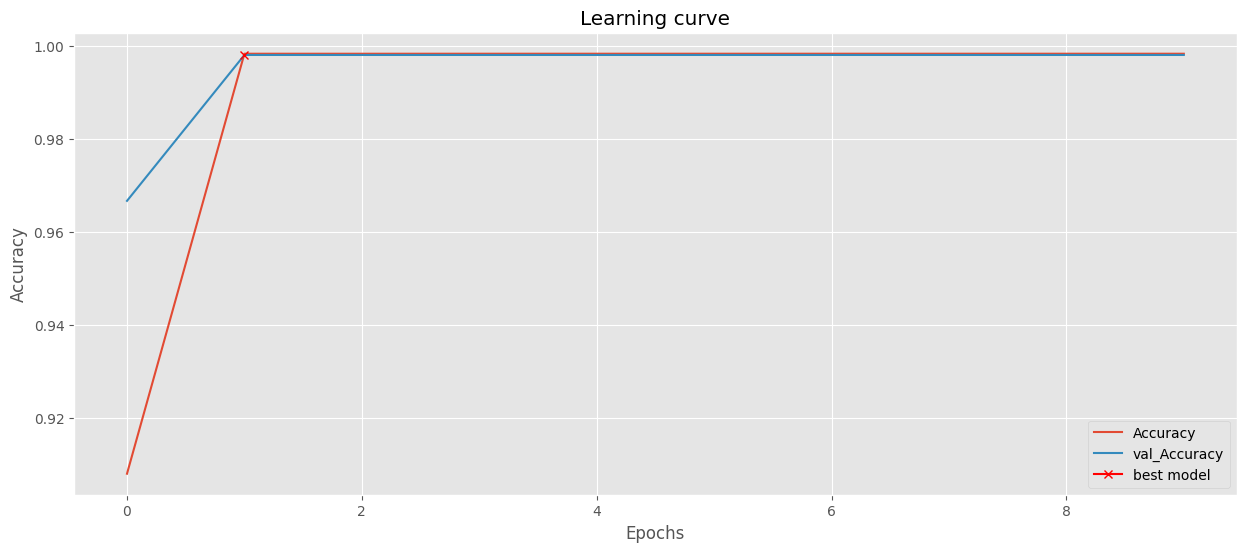

In [15]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# **Inference**

In [ ]:
model.load_weights('model-UnetPP.h5')

In [ ]:
model.evaluate(images_test, masks_test, verbose=1)

In [ ]:
# Predict on train, val and test
preds = model.predict(images_test, verbose=1)

In [ ]:
# Threshold predictions
preds_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('MS Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('MS Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('MS Image Predicted')
    ax[2].set_axis_off()

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('MS Mask Image Predicted binary');
    ax[3].set_axis_off()

# **Predictions on training set**

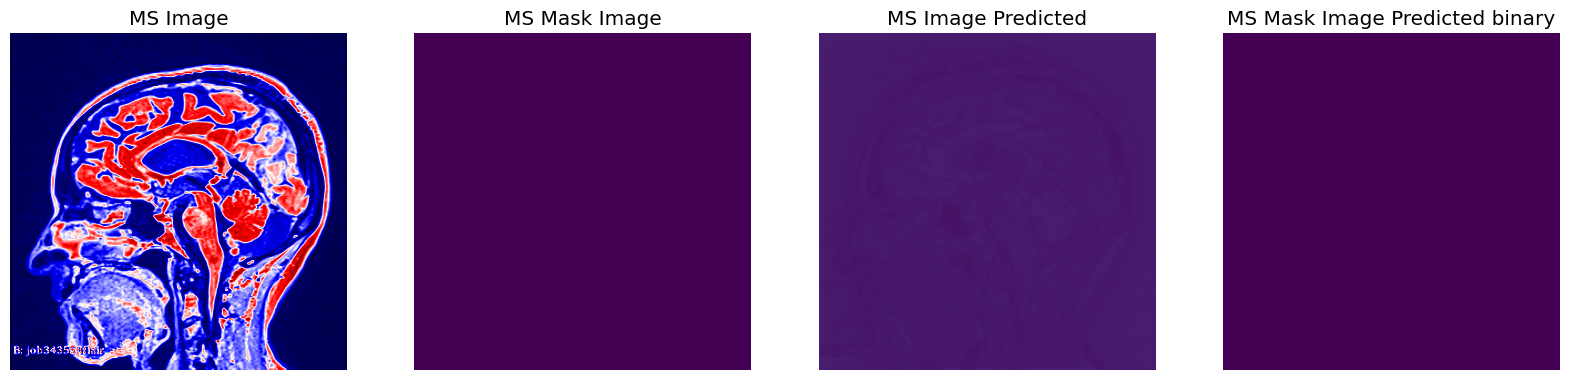

In [ ]:
# Check if training data looks all right
plot_sample(images_train, masks_train, preds, preds_t)

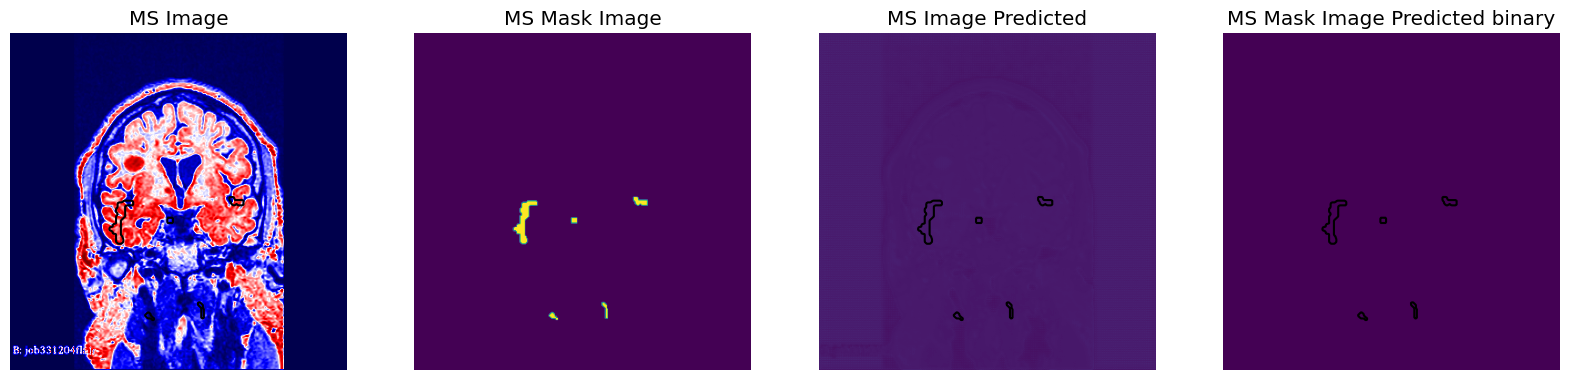

In [ ]:
plot_sample(images_train, masks_train, preds_train, preds_train_t)

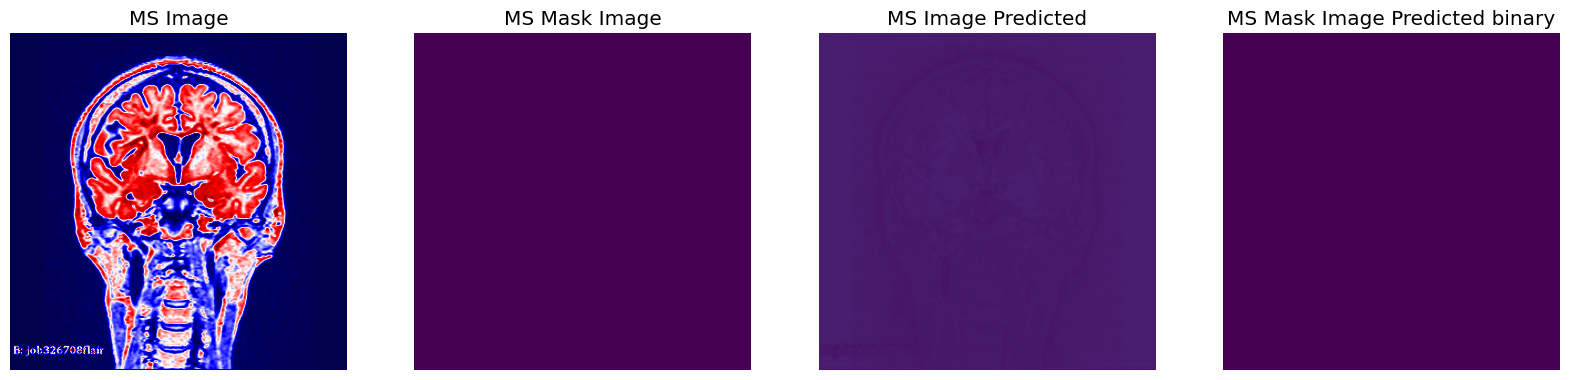

In [ ]:
plot_sample(images_train, masks_train, preds_train, preds_train_t)

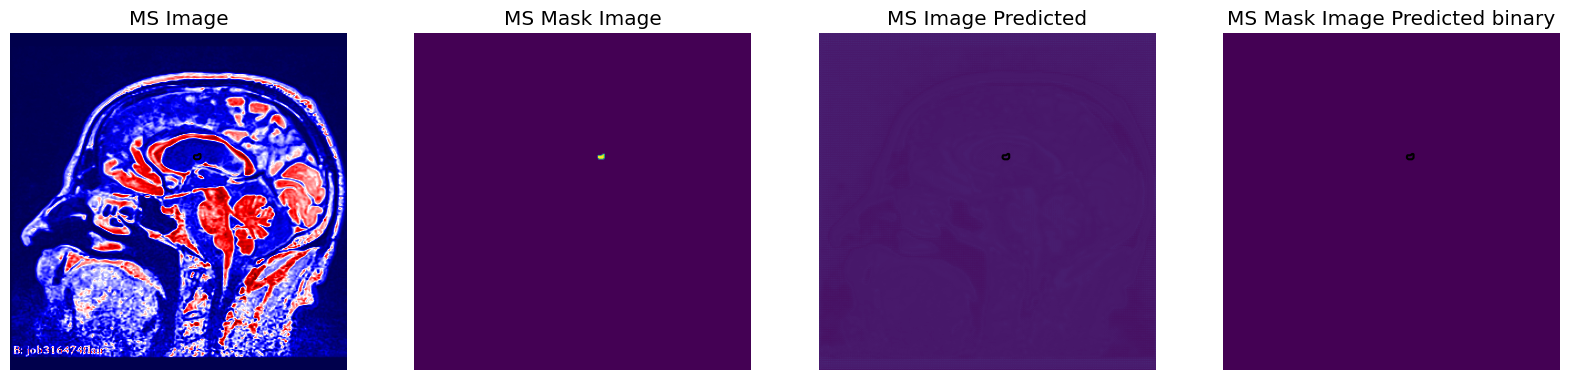

In [ ]:
plot_sample(images_train, masks_train, preds_train, preds_train_t)

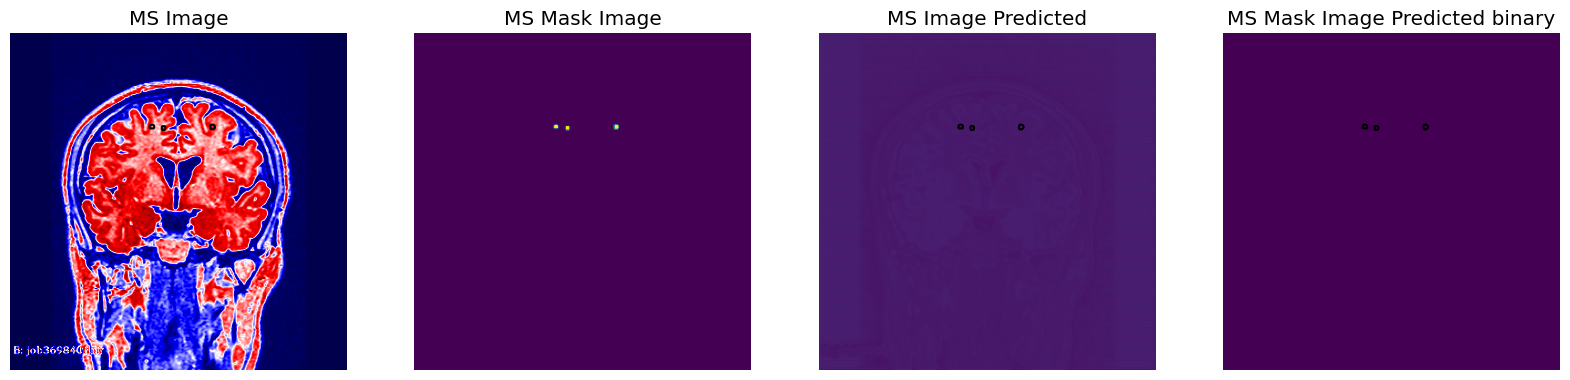

In [ ]:
plot_sample(images_train, masks_train, preds_train, preds_train_t)

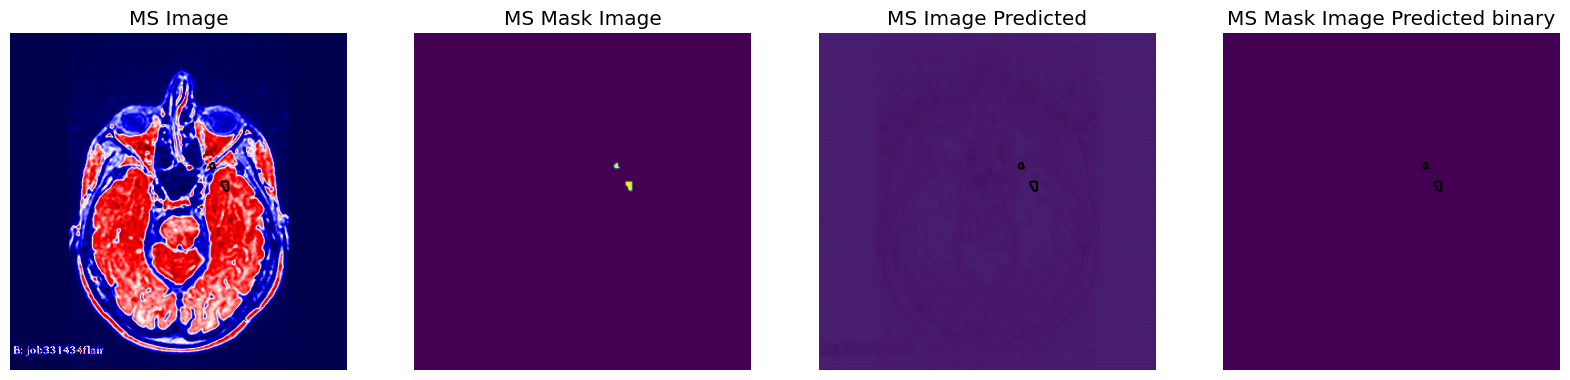

In [ ]:
plot_sample(images_train, masks_train, preds_train, preds_train_t)